In [ ]:
import pandas as pd
import numpy as np
import datetime as dt

import lightgbm as lgb
import xgboost as xgb
from xgboost import XGBRegressor, plot_importance

#from pmdarima import auto_arima

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, RNN, Input, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
df = pd.read_csv('/kaggle/input/nifty50-stock-market-data/INFY.csv')
df.set_index('Date', drop=False, inplace=True)
df.head()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,,
2000-01-03,2000-01-03,INFOSYSTCH,EQ,14467.75,15625.00,15625.20,15625.00,15625.20,15625.20,15625.18,5137,8.026657e+12,NaN,NaN,NaN
2000-01-04,2000-01-04,INFOSYSTCH,EQ,15625.20,16800.00,16875.25,16253.00,16875.25,16855.90,16646.38,56186,9.352937e+13,NaN,NaN,NaN
2000-01-05,2000-01-05,INFOSYSTCH,EQ,16855.90,15701.00,16250.00,15507.45,15507.45,15507.45,15786.38,164605,2.598516e+14,NaN,NaN,NaN
2000-01-06,2000-01-06,INFOSYSTCH,EQ,15507.45,15256.65,15300.00,14266.85,14266.85,14266.85,14462.82,81997,1.185908e+14,NaN,NaN,NaN
2000-01-07,2000-01-07,INFOSYSTCH,EQ,14266.85,13125.50,13125.50,13125.50,13125.50,13125.50,13125.50,7589,9.960942e+12,NaN,NaN,NaN


In [ ]:
df.tail()

,Date,Symbol,Series,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,,,
2021-04-26,2021-04-26,INFY,EQ,1333.80,1332.25,1351.3,1321.00,1345.0,1343.55,1343.19,7088606,9.521361e+14,130375.0,4218129.0,0.5951
2021-04-27,2021-04-27,INFY,EQ,1343.55,1346.00,1353.0,1340.15,1347.5,1348.50,1346.89,3636115,4.897445e+14,145974.0,1871084.0,0.5146
2021-04-28,2021-04-28,INFY,EQ,1348.50,1358.00,1359.5,1344.60,1355.8,1356.00,1353.45,4879234,6.603778e+14,137376.0,2857134.0,0.5856
2021-04-29,2021-04-29,INFY,EQ,1356.00,1368.00,1369.0,1351.40,1356.0,1356.35,1360.05,5412357,7.361090e+14,119277.0,3130945.0,0.5785
2021-04-30,2021-04-30,INFY,EQ,1356.35,1346.30,1373.9,1345.90,1348.6,1354.35,1361.16,8354677,1.137203e+15,131718.0,5408113.0,0.6473


In [ ]:
df.isna().sum()

Date                     0
Symbol                   0
Series                   0
Prev Close               0
Open                     0
High                     0
Low                      0
Last                     0
Close                    0
VWAP                     0
Volume                   0
Turnover                 0
Trades                2850
Deliverable Volume     509
%Deliverble            509
dtype: int64

In [ ]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Prev Close,5306.0,2.584357e+03,1.796807e+03,5.264500e+02,1.216062e+03,2.265675e+03,3.170562e+03,1.685590e+04
Open,5306.0,2.584665e+03,1.796732e+03,5.092500e+02,1.213675e+03,2.265000e+03,3.174762e+03,1.680000e+04
High,5306.0,2.626204e+03,1.842171e+03,5.580000e+02,1.233675e+03,2.294300e+03,3.210038e+03,1.687525e+04
Low,5306.0,2.539065e+03,1.743052e+03,5.092500e+02,1.197925e+03,2.232475e+03,3.124575e+03,1.625300e+04
Last,5306.0,2.581678e+03,1.789259e+03,5.291500e+02,1.215750e+03,2.263275e+03,3.170750e+03,1.687525e+04
Close,5306.0,2.581885e+03,1.789463e+03,5.264500e+02,1.216062e+03,2.265575e+03,3.169350e+03,1.685590e+04
VWAP,5306.0,2.582750e+03,1.792981e+03,5.313300e+02,1.214648e+03,2.262210e+03,3.168457e+03,1.664638e+04
Volume,5306.0,2.622813e+06,4.202984e+06,3.291000e+03,7.166842e+05,1.210798e+06,2.784006e+06,9.043339e+07
Turnover,5306.0,3.855758e+14,3.808224e+14,2.933192e+12,2.065910e+14,2.911119e+14,4.335687e+14,8.323905e+15
Trades,2456.0,1.118490e+05,9.020307e+04,1.350000e+03,5.922600e+04,9.025650e+04,1.354770e+05,1.643015e+06


In [ ]:
df.drop(['Symbol','Series'],axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5306 entries, 2000-01-03 to 2021-04-30
Data columns (total 13 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                5306 non-null   object 
 1   Prev Close          5306 non-null   float64
 2   Open                5306 non-null   float64
 3   High                5306 non-null   float64
 4   Low                 5306 non-null   float64
 5   Last                5306 non-null   float64
 6   Close               5306 non-null   float64
 7   VWAP                5306 non-null   float64
 8   Volume              5306 non-null   int64  
 9   Turnover            5306 non-null   float64
 10  Trades              2456 non-null   float64
 11  Deliverable Volume  4797 non-null   float64
 12  %Deliverble         4797 non-null   float64
dtypes: float64(11), int64(1), object(1)
memory usage: 580.3+ KB


<AxesSubplot:>

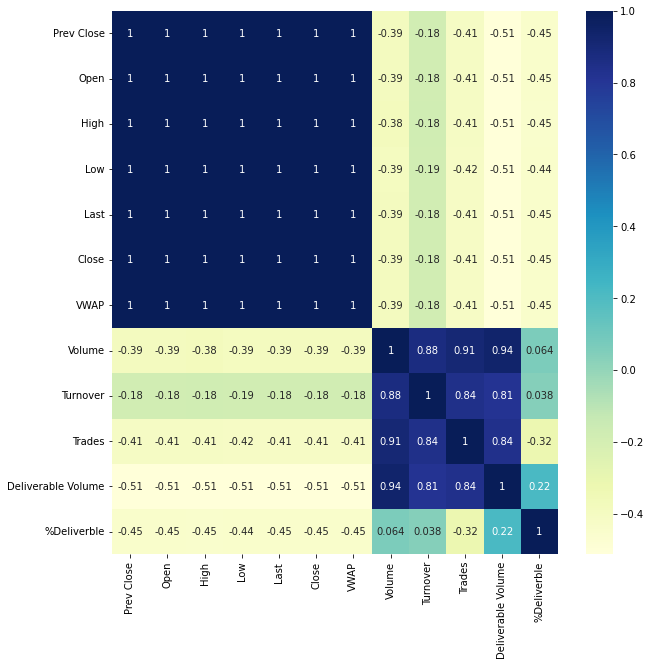

In [ ]:
# correlation

plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), cmap='YlGnBu', annot=True)

In [ ]:
df.head()

,Date,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,Trades,Deliverable Volume,%Deliverble
Date,,,,,,,,,,,,,
2000-01-03,2000-01-03,14467.75,15625.00,15625.20,15625.00,15625.20,15625.20,15625.18,5137,8.026657e+12,NaN,NaN,NaN
2000-01-04,2000-01-04,15625.20,16800.00,16875.25,16253.00,16875.25,16855.90,16646.38,56186,9.352937e+13,NaN,NaN,NaN
2000-01-05,2000-01-05,16855.90,15701.00,16250.00,15507.45,15507.45,15507.45,15786.38,164605,2.598516e+14,NaN,NaN,NaN
2000-01-06,2000-01-06,15507.45,15256.65,15300.00,14266.85,14266.85,14266.85,14462.82,81997,1.185908e+14,NaN,NaN,NaN
2000-01-07,2000-01-07,14266.85,13125.50,13125.50,13125.50,13125.50,13125.50,13125.50,7589,9.960942e+12,NaN,NaN,NaN


'Date','Open','High','Low','Volume','VWAP' are highly correlated

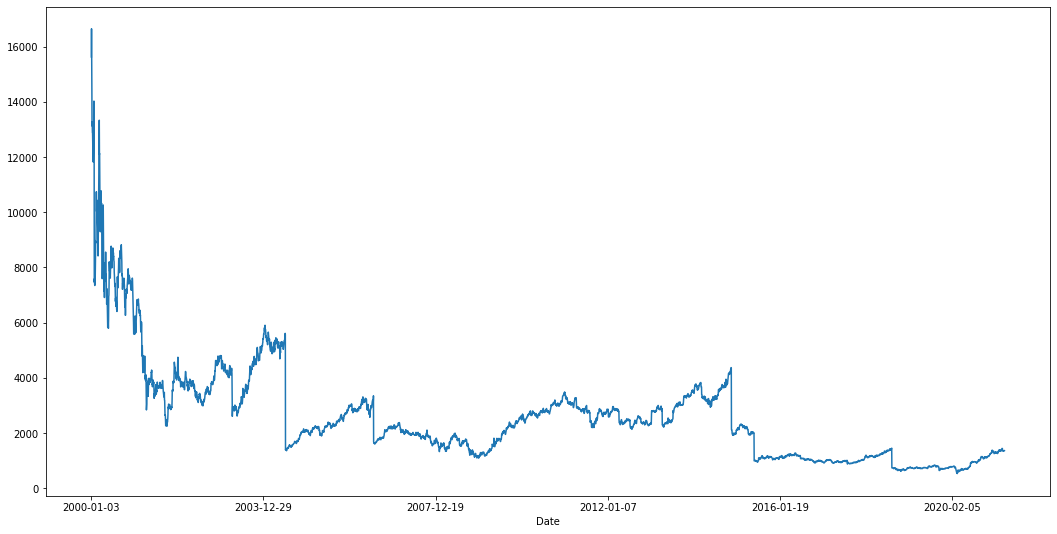

In [ ]:
df.VWAP.plot(figsize=(18,9));

## Feature Engineering

In [ ]:
df.reset_index(drop=True, inplace=True)
lag_features = ['High','Low','Volume','Turnover','Trades']
window1 = 3
window2 = 7
window3 = 30

df_rolled_3d = df[lag_features].rolling(window=window1, min_periods=0)
df_rolled_7d = df[lag_features].rolling(window=window2, min_periods=0)
df_rolled_30d = df[lag_features].rolling(window=window3, min_periods=0)

df_mean_3d = df_rolled_3d.mean().shift(1).reset_index().astype(np.float64)
df_mean_7d = df_rolled_7d.mean().shift(1).reset_index().astype(np.float64)
df_mean_30d = df_rolled_30d.mean().shift(1).reset_index().astype(np.float64)

df_std_3d = df_rolled_3d.std().shift(1).reset_index().astype(np.float64)
df_std_7d = df_rolled_7d.std().shift(1).reset_index().astype(np.float64)
df_std_30d = df_rolled_30d.std().shift(1).reset_index().astype(np.float64)

for feature in lag_features:
    df[f"{feature}_mean_lag{window1}"] = df_mean_3d[feature]
    df[f"{feature}_mean_lag{window2}"] = df_mean_7d[feature]
    df[f"{feature}_mean_lag{window3}"] = df_mean_30d[feature]

    df[f"{feature}_std_lag{window1}"] = df_std_3d[feature]
    df[f"{feature}_std_lag{window2}"] = df_std_7d[feature]
    df[f"{feature}_std_lag{window3}"] = df_std_30d[feature]

df['Daily Return'] = df['Close'].pct_change()

df.fillna(df.mean(), inplace=True)
df.head()


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.


,Date,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,...,Turnover_std_lag3,Turnover_std_lag7,Turnover_std_lag30,Trades_mean_lag3,Trades_mean_lag7,Trades_mean_lag30,Trades_std_lag3,Trades_std_lag7,Trades_std_lag30,Daily Return
0,2000-01-03,14467.75,15625.00,15625.20,15625.00,15625.20,15625.20,15625.18,5137,8.026657e+12,...,1.319807e+14,1.650958e+14,2.173573e+14,111807.525866,111721.804472,110781.735637,33833.777083,42355.022823,55887.310701,0.000119
1,2000-01-04,15625.20,16800.00,16875.25,16253.00,16875.25,16855.90,16646.38,56186,9.352937e+13,...,1.319807e+14,1.650958e+14,2.173573e+14,111807.525866,111721.804472,110781.735637,33833.777083,42355.022823,55887.310701,0.078764
2,2000-01-05,16855.90,15701.00,16250.00,15507.45,15507.45,15507.45,15786.38,164605,2.598516e+14,...,6.045955e+13,6.045955e+13,6.045955e+13,111807.525866,111721.804472,110781.735637,33833.777083,42355.022823,55887.310701,-0.079999
3,2000-01-06,15507.45,15256.65,15300.00,14266.85,14266.85,14266.85,14462.82,81997,1.185908e+14,...,1.280557e+14,1.280557e+14,1.280557e+14,111807.525866,111721.804472,110781.735637,33833.777083,42355.022823,55887.310701,-0.080000
4,2000-01-07,14266.85,13125.50,13125.50,13125.50,13125.50,13125.50,13125.50,7589,9.960942e+12,...,8.967144e+13,1.045613e+14,1.045613e+14,111807.525866,111721.804472,110781.735637,33833.777083,42355.022823,55887.310701,-0.080000


For boosting models, it is very useful to add datetime features like hour, day, month, as applicable to provide the model information about the time component in the data. For time series models it is not explicitly required to pass this information

In [ ]:
# extracting date time features
df.Date = pd.to_datetime(df.Date, format='%Y-%m-%d')
df['month'] = df.Date.dt.month
df["week"] = df.Date.dt.week
df['day'] = df.Date.dt.month
df['day_of_week'] = df.Date.dt.dayofweek

df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', drop=False, inplace=True)

df.head()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  after removing the cwd from sys.path.


,Date,Prev Close,Open,High,Low,Last,Close,VWAP,Volume,Turnover,...,Trades_mean_lag7,Trades_mean_lag30,Trades_std_lag3,Trades_std_lag7,Trades_std_lag30,Daily Return,month,week,day,day_of_week
Date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,2000-01-03,14467.75,15625.00,15625.20,15625.00,15625.20,15625.20,15625.18,5137,8.026657e+12,...,111721.804472,110781.735637,33833.777083,42355.022823,55887.310701,0.000119,1,1,1,0
2000-01-04,2000-01-04,15625.20,16800.00,16875.25,16253.00,16875.25,16855.90,16646.38,56186,9.352937e+13,...,111721.804472,110781.735637,33833.777083,42355.022823,55887.310701,0.078764,1,1,1,1
2000-01-05,2000-01-05,16855.90,15701.00,16250.00,15507.45,15507.45,15507.45,15786.38,164605,2.598516e+14,...,111721.804472,110781.735637,33833.777083,42355.022823,55887.310701,-0.079999,1,1,1,2
2000-01-06,2000-01-06,15507.45,15256.65,15300.00,14266.85,14266.85,14266.85,14462.82,81997,1.185908e+14,...,111721.804472,110781.735637,33833.777083,42355.022823,55887.310701,-0.080000,1,1,1,3
2000-01-07,2000-01-07,14266.85,13125.50,13125.50,13125.50,13125.50,13125.50,13125.50,7589,9.960942e+12,...,111721.804472,110781.735637,33833.777083,42355.022823,55887.310701,-0.080000,1,1,1,4


In [ ]:
df.columns

Index(['Date', 'Prev Close', 'Open', 'High', 'Low', 'Last', 'Close', 'VWAP',
       'Volume', 'Turnover', 'Trades', 'Deliverable Volume', '%Deliverble',
       'High_mean_lag3', 'High_mean_lag7', 'High_mean_lag30', 'High_std_lag3',
       'High_std_lag7', 'High_std_lag30', 'Low_mean_lag3', 'Low_mean_lag7',
       'Low_mean_lag30', 'Low_std_lag3', 'Low_std_lag7', 'Low_std_lag30',
       'Volume_mean_lag3', 'Volume_mean_lag7', 'Volume_mean_lag30',
       'Volume_std_lag3', 'Volume_std_lag7', 'Volume_std_lag30',
       'Turnover_mean_lag3', 'Turnover_mean_lag7', 'Turnover_mean_lag30',
       'Turnover_std_lag3', 'Turnover_std_lag7', 'Turnover_std_lag30',
       'Trades_mean_lag3', 'Trades_mean_lag7', 'Trades_mean_lag30',
       'Trades_std_lag3', 'Trades_std_lag7', 'Trades_std_lag30',
       'Daily Return', 'month', 'week', 'day', 'day_of_week'],
      dtype='object')

### RNN n Friends

In [ ]:
def rmse(x, y):
    return np.round(np.sqrt(mean_squared_error(x,y)), 4)

In [ ]:
def create_dataset(df, look_back, look_ahead):
    xdat, ydat = [], []
    for i in range(len(df) - look_back - look_ahead):
        xdat.append(df[i:i+look_back,0])
        ydat.append(df[i+look_back: i+look_back+look_ahead,0])

    xdat, ydat = np.array(xdat), np.array(ydat).reshape(-1, look_ahead)
    return xdat, ydat

In [ ]:
def prepare_split(xdat, ydat, cutoff=5000, timesteps=50):
    xtrain, xvalid = xdat[:cutoff, :], xdat[cutoff:,]
    ytrain, yvalid = ydat[:cutoff, :], ydat[cutoff:,]

    # reshape into [batch size, time steps, dimensionality]
    xtrain = xtrain.reshape(-1, timesteps, 1)
    xvalid = xvalid.reshape(-1, timesteps, 1)

    return xtrain, ytrain, xvalid, yvalid

<AxesSubplot:xlabel='Date'>

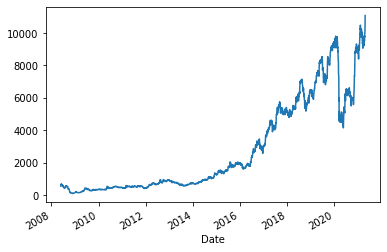

In [ ]:
df = pd.read_csv("/kaggle/input/nifty50-stock-market-data/BAJAJFINSV.csv", usecols=['Date', 'VWAP'])
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)
df.VWAP.plot()

    When dealing with time series through RNN we typically - wrappers like Kats or darts notwithstanding - need to format the input data into a shape [batch size, time steps, dimensionality] where the last one is 1 for univariate series (single step ahead predictions) and more for multivariate ones (including univariate series + covariates

In [ ]:
scaler = MinMaxScaler()
df = scaler.fit_transform(df)

In [ ]:
# use 50 historical observation and predict 1 step ahead

look_back = 50
look_ahead = 1

xdat, ydat = create_dataset(df, look_back, look_ahead)

print(xdat.shape, ydat.shape)

(3150, 50) (3150, 1)


Our prepare_split function takes care of reshaping the data into [batch size, time steps, dimensionality]

In [ ]:
xtrain, ytrain, xvalid, yvalid = prepare_split(xdat, ydat, cutoff = 3000, timesteps = look_back)

print(xtrain.shape, xvalid.shape, ytrain.shape, yvalid.shape)

(3000, 50, 1) (150, 50, 1) (3000, 1) (150, 1)


In [ ]:
# simple RNN model

def create_model():
    model = Sequential()
    model.add(SimpleRNN(10, input_shape=[None, 1]))
    model.add(Dense(1))

    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = create_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 10)                120       
_________________________________________________________________
dense (Dense)                (None, 1)                 11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [ ]:
early_stop = EarlyStopping(monitor = 'val_loss', min_delta = 0.001,
                           patience = 5, mode = 'min', verbose = 1,
                           restore_best_weights = True)

model.fit(xtrain, ytrain, validation_data=(xvalid, yvalid),
           epochs = 10,
           batch_size = 16,
           callbacks=[ early_stop])

Epoch 1/10
188/188 [==============================] - 4s 12ms/step - loss: 7.7129e-04 - val_loss: 0.0014
Epoch 2/10
188/188 [==============================] - 2s 11ms/step - loss: 1.2762e-04 - val_loss: 7.4763e-04
Epoch 3/10
188/188 [==============================] - 2s 10ms/step - loss: 1.0115e-04 - val_loss: 6.3290e-04
Epoch 4/10
188/188 [==============================] - 2s 11ms/step - loss: 8.7385e-05 - val_loss: 3.8386e-04
Epoch 5/10
188/188 [==============================] - 2s 10ms/step - loss: 7.8597e-05 - val_loss: 3.9580e-04
Epoch 6/10
188/188 [==============================] - 2s 10ms/step - loss: 7.8366e-05 - val_loss: 3.0242e-04
Epoch 7/10
188/188 [==============================] - 2s 10ms/step - loss: 7.0680e-05 - val_loss: 2.8567e-04
Epoch 8/10
188/188 [==============================] - 2s 10ms/step - loss: 6.8346e-05 - val_loss: 6.9129e-04
Epoch 9/10
188/188 [==============================] - 2s 11ms/step - loss: 6.7000e-05 - val_loss: 3.1697e-04
Epoch 10/10
188/188 [==

In [ ]:
y_pred = model.predict(xvalid)
y_pred = scaler.inverse_transform(y_pred)
yvalid1 = scaler.inverse_transform(yvalid)

In [ ]:
print('RMSE:'+str(rmse(y_pred, scaler.inverse_transform(yvalid))))
print('RMSE:'+str(np.sqrt(mean_squared_error(y_pred, yvalid1))))

RMSE:207.6595
RMSE:207.65945244105248


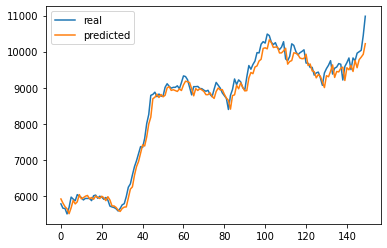

In [ ]:
plt.plot(yvalid1, label = 'real')
plt.plot(y_pred, label = 'predicted')
plt.ylabel('')
plt.legend()
plt.show()

### GRU

Same workflow, different operation inside a unit

    * used a hidden state

    * two gates: reset and update  →  control how much / which information to retain

    * reset gate: used to decide whether the previous cell state is important or not; not always used. If close to 0, previous hidden state is mostly ignored: model drops information irrelevant to the future.

    * update gate: decides if the cell state should be updated with the candidate state (current activation value) or not. If close to 1, we can copy information in that unit through subsequent steps

    * candidate cell: hidden state(activation) of RNN

    * final cell state: dependent on the update gate, It may or may not be updated with candidate state. Remove some content from last cell state, and write some new cell content. In GRU the final cell state is directly passing as the activation to the next cell.

In [ ]:
def create_model(out_dim):
    model = Sequential()
    model.add(GRU(10, input_shape=[None, 1], return_sequences=True))
    model.add(GRU(10, input_shape=[None, 1]))
    model.add(Dense(out_dim))

    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

model = create_model(look_ahead)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 10)          390       
_________________________________________________________________
gru_1 (GRU)                  (None, 10)                660       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 1,061
Trainable params: 1,061
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(xtrain, ytrain,
          validation_data=(xvalid, yvalid),
          epochs = 10,
          batch_size = 16,
          callbacks=[early_stop])

y_pred = model.predict(xvalid)
y_pred = scaler.inverse_transform(y_pred)
yvalid1 = scaler.inverse_transform(yvalid)
print('RMSE:'+ str(rmse(y_pred, yvalid1)))

Epoch 1/10
188/188 [==============================] - 16s 62ms/step - loss: 0.0091 - val_loss: 0.0010
Epoch 2/10
188/188 [==============================] - 10s 53ms/step - loss: 1.3662e-04 - val_loss: 6.7237e-04
Epoch 3/10
188/188 [==============================] - 10s 54ms/step - loss: 1.1742e-04 - val_loss: 5.8994e-04
Epoch 4/10
188/188 [==============================] - 11s 57ms/step - loss: 1.0381e-04 - val_loss: 5.1820e-04
Epoch 5/10
188/188 [==============================] - 11s 56ms/step - loss: 9.8580e-05 - val_loss: 5.6629e-04
Epoch 6/10
188/188 [==============================] - 10s 54ms/step - loss: 8.4760e-05 - val_loss: 4.6298e-04
Restoring model weights from the end of the best epoch.
Epoch 00006: early stopping
RMSE:354.3184
